In [1]:
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [2]:
# Parameters
WINDOW_SIZE = (256,256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 4 # Number of input channels (e.g. RGB)
FOLDER = "ISPRS_dataset/" 
BATCH_SIZE = 10 # Number of samples in a mini-batch

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Vaihingen'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    # Uncomment the next line for IRRG data
    # DATA_FOLDER = MAIN_FOLDER + '3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    # For RGB data
    DATA_FOLDER = MAIN_FOLDER + '2_Ortho_RGB/top_potsdam_{}_RGB.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'IR-R-G-NDSM(4 channel)/image{}.png'
    LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'

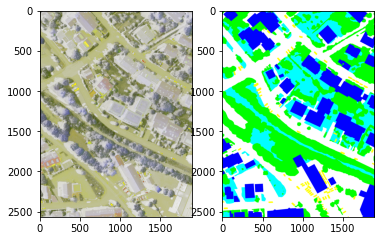

Ground truth in numerical format has shape (2566,1893) : 
 [[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


In [3]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread('ISPRS_dataset/Vaihingen/IR-R-G-NDSM(4 channel)/image11.png')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread('ISPRS_dataset/Vaihingen/gts_for_participants/top_mosaic_09cm_area11.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)


In [4]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def cross_entropy2d(input, target, weight=None, size_average=True):
    dim = input.dim()
    n, c, h, w = input.size()
    nt, ht, wt = target.size()
    
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)

    # Handle inconsistent size between input and target
    elif dim == 4:
        output = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)
        output = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [5]:
# Dataset class

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

In [8]:
from torch import nn
from torchvision import models
import torch.nn.functional as F

In [9]:
class AAM(nn.Module):
    def __init__(self, in_ch,out_ch):
        super(AAM, self).__init__()
        self.global_pooling = nn.AdaptiveAvgPool2d(1)

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, padding=0),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, padding=0),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

        self.conv3 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 1, padding=0),
            nn.Softmax(dim=1))

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, padding=0),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, input_high, input_low):
        mid_high=self.global_pooling(input_high)
        weight_high=self.conv1(mid_high)

        mid_low = self.global_pooling(input_low)
        weight_low = self.conv2(mid_low)

        weight=self.conv3(weight_low+weight_high)
        low = self.conv4(input_low)
        return input_high+low.mul(weight)


In [10]:
class DecoderBlockLinkNet(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C/4, 2 * H, 2 * W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)


    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        return x

In [11]:
class Resnet34_4(nn.Module):
    def __init__(self, pre=True):
        super().__init__()
        encoder = models.resnet34(pretrained=pre)
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if(pre):
            w = encoder.conv1.weight
            self.conv1.weight = nn.Parameter(torch.cat((w,
                                    0.5*(w[:,:1,:,:]+w[:,2:,:,:])),dim=1))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = nn.Sequential(self.conv1,self.relu,self.bn1,self.maxpool)
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        #the head will be added automatically by fast.ai
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x

In [12]:
class RAUNet(nn.Module):
    def __init__(self, num_classes=6, num_channels=4, pretrained=True):
        super().__init__()
        assert num_channels == 4
        self.w = 512
        self.h = 640
        self.num_classes = num_classes
        filters = [64, 128, 256, 512]
        resnet = Resnet34_4()
        # filters = [256, 512, 1024, 2048]
        # resnet = models.resnet50(pretrained=pretrained)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlockLinkNet(filters[3], filters[2])
        self.decoder3 = DecoderBlockLinkNet(filters[2], filters[1])
        self.decoder2 = DecoderBlockLinkNet(filters[1], filters[0])
        self.decoder1 = DecoderBlockLinkNet(filters[0], filters[0])
        self.gau3 = AAM(filters[2], filters[2]) #RAUNet
        self.gau2 = AAM(filters[1], filters[1])
        self.gau1 = AAM(filters[0], filters[0])


        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4)
        b4 = self.gau3(d4, e3)
        d3 = self.decoder3(b4)
        b3 = self.gau2(d3, e2)
        d2 = self.decoder2(b3)
        b2 = self.gau1(d2, e1)
        d1 = self.decoder1(b2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        if self.num_classes > 1:
            x_out = F.log_softmax(f5, dim=1)
        else:
            x_out = f5
        return x_out

In [57]:
class SqueezeExcitation(nn.Module):
    def __init__(self, nb_channels, reduction=16):
        super(SqueezeExcitation, self).__init__()
        self.nb_channels=nb_channels
        self.avg_pool=nn.AdaptiveAvgPool2d(1)
        self.fc=nn.Sequential(
                nn.Linear(nb_channels, nb_channels // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(nb_channels // reduction, nb_channels),
                nn.Sigmoid())

        
    def forward(self, x):
        y = self.avg_pool(x).view(-1,self.nb_channels)
        y = self.fc(y).view(-1,self.nb_channels,1,1)
        return x * y
    

In [58]:
class ConvBlock(nn.Module):

    def __init__(self,
            in_ch,
            in_size,
            depth=2, 
            kernel_size=3, 
            stride=1, 
            padding=0, 
            out_ch=None,
            bn=True,
            se=True,
            act='relu',
            act_kwargs={}):
        super(ConvBlock, self).__init__()
        self.out_ch=out_ch or 2*in_ch
        self._set_post_processes(self.out_ch,bn,se,act,act_kwargs)
        self._set_conv_layers(
            depth,
            in_ch,
            kernel_size,
            stride,
            padding)
        self.out_size=in_size-depth*2*((kernel_size-1)/2-padding)

        
    def forward(self, x):
        x=self.conv_layers(x)
        if self.bn:
            x=self.bn(x)
        if self.act:
            x=self._activation(x)
        if self.se:
            x=self.se(x)
        return x

    
    def _set_post_processes(self,out_channels,bn,se,act,act_kwargs):
        if bn:
            self.bn=nn.BatchNorm2d(out_channels)
        else:
            self.bn=False
        if se:
            self.se=SqueezeExcitation(out_channels)
        else:
            self.se=False
        self.act=act
        self.act_kwargs=act_kwargs
        
    def _set_conv_layers(
            self,
            depth,
            in_ch,
            kernel_size,
            stride,
            padding):
        layers=[]
        for index in range(depth):
            if index!=0:
                in_ch=self.out_ch
            layers.append(
                nn.Conv2d(
                    in_channels=in_ch,
                    out_channels=self.out_ch,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding))
        self.conv_layers=nn.Sequential(*layers)

        
    def _activation(self,x):
        return getattr(F,self.act,**self.act_kwargs)(x)

    
conv_block=ConvBlock(1,572,out_ch=64)
print(conv_block.out_size,conv_block.out_ch)
print(conv_block(torch.rand(1,1,572,572)).shape)


568.0 64
torch.Size([1, 64, 568, 568])


In [59]:
class DownBlock(nn.Module):
    
    def __init__(self,
            in_ch,
            in_size,
            out_ch=None,
            depth=2,
            padding=0,
            bn=True,
            se=True,
            act='relu',
            act_kwargs={}):
        super(DownBlock, self).__init__()
        self.out_size=(in_size//2)-depth*(1-padding)*2
        self.out_ch=out_ch or in_ch*2
        self.down=nn.MaxPool2d(kernel_size=2)
        self.conv_block=ConvBlock(
            in_ch=in_ch,
            out_ch=self.out_ch,
            in_size=in_size//2,
            depth=depth,
            padding=padding,
            bn=bn,
            se=se,
            act=act,
            act_kwargs=act_kwargs)

        
    def forward(self, x):
        x=self.down(x)
        return self.conv_block(x)

    
db_out=DownBlock(64,568,depth=4)
print(db_out.out_size,db_out.out_ch)
print(db_out(torch.rand(1,64,568,568)).shape)

276 128
torch.Size([1, 128, 276, 276])


In [60]:
class UpBlock(nn.Module):
    
    @staticmethod
    def cropping(skip_size,size):
        return (skip_size-size)//2
    
    
    def __init__(self,
            in_ch,
            in_size,
            out_ch=None,
            bilinear=False,
            crop=None,
            depth=2,
            padding=0,
            bn=True,
            se=True,
            act='relu',
            act_kwargs={}):
        super(UpBlock, self).__init__()
        self.crop=crop
        self.padding=padding
        self.out_size=(in_size*2)-depth*(1-padding)*2
        self.out_ch=out_ch or in_ch//2
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)
        self.conv_block=ConvBlock(
            in_ch,
            self.out_size,
            out_ch=self.out_ch,
            depth=depth,
            padding=padding,
            bn=bn,
            se=se,
            act=act,
            act_kwargs=act_kwargs)
        
        
    def forward(self, x, skip):
        x = self.up(x)
        skip = self._crop(skip,x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv_block(x)
        return x

    
    def _crop(self,skip,x):
        if self.padding is 0:
            if self.crop is None:
                self.crop=self.cropping(skip.size()[-1],x.size()[-1])
            skip=skip[:,:,self.crop:-self.crop,self.crop:-self.crop]
            skip=int(skip)
        return skip

db_out=UpBlock(256,100)

In [61]:
class UNet(nn.Module):

    def __init__(self,
            network_depth=4,
            conv_depth=2,
            in_size=572,
            in_ch=3,
            out_ch=2,
            init_ch=64,
            padding=0,
            bn=True,
            se=True,
            act='relu',
            act_kwargs={}):
        super(UNet, self).__init__()
        self.network_depth=network_depth
        self.conv_depth=conv_depth
        self.out_ch=out_ch
        self.padding=padding
        self.input_conv=ConvBlock(
            in_ch=in_ch,
            in_size=in_size,
            out_ch=init_ch,
            depth=self.conv_depth,
            padding=padding,
            bn=bn,
            se=se,
            act=act,
            act_kwargs=act_kwargs)
        down_layers=self._down_layers(
            self.input_conv.out_ch,
            self.input_conv.out_size,
            bn=bn,
            se=se,
            act=act,
            act_kwargs=act_kwargs)
        self.down_blocks=nn.ModuleList(down_layers)
        up_layers=self._up_layers(
            down_layers,
            bn=bn,
            se=se,
            act=act,
            act_kwargs=act_kwargs)
        self.up_blocks=nn.ModuleList(up_layers)
        self.out_size=self.up_blocks[-1].out_size
        self.output_conv=self._output_layer(out_ch)

        
    def forward(self, x):
        x=self.input_conv(x)
        skips=[x]
        for block in self.down_blocks:
            x=block(x)
            skips.append(x)
        skips.pop()
        skips=skips[::-1]
        for skip,block in zip(skips,self.up_blocks):
            x=block(x,skip)
        x=self.output_conv(x)
        return x
    
    
    def _down_layers(self,in_ch,in_size,bn,se,act,act_kwargs):
        layers=[]
        for index in range(1,self.network_depth+1):
            layer=DownBlock(
                in_ch,
                in_size,
                depth=self.conv_depth,
                padding=self.padding,
                bn=bn,
                se=se,
                act=act,
                act_kwargs=act_kwargs)
            in_ch=layer.out_ch
            in_size=layer.out_size
            layers.append(layer)
        return layers

        
    def _up_layers(self,down_layers,bn,se,act,act_kwargs):
        down_layers=down_layers[::-1]
        down_layers.append(self.input_conv)
        first=down_layers.pop(0)
        in_ch=first.out_ch
        in_size=first.out_size
        layers=[]
        for down_layer in down_layers:
            crop=UpBlock.cropping(down_layer.out_size,2*in_size)
            layer=UpBlock(
                in_ch,
                in_size,
                depth=self.conv_depth,
                crop=crop,
                padding=self.padding,
                bn=bn,
                se=se,
                act=act,
                act_kwargs=act_kwargs)
            in_ch=layer.out_ch
            in_size=layer.out_size
            layers.append(layer)
        return layers

    
    def _output_layer(self,out_ch):
        return nn.Conv2d(
           in_channels=64,
           out_channels=out_ch,
           kernel_size=1,
           stride=1,
           padding=0)

unet=UNet(in_size=572,network_depth=4,conv_depth=2)

In [7]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x




In [8]:
class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


In [9]:
class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

In [10]:
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1

In [11]:
class Up(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x



In [12]:
class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

In [13]:
class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


In [14]:
class AttU_Net_a(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=3, output_ch=6):
        super(AttU_Net_a, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = RRCNN_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = RRCNN_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = RRCNN_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = RRCNN_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)
        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out

In [31]:
%%bash
git clone https://github.com/meetshah1995/pytorch-semseg.git

Cloning into 'pytorch-semseg'...


In [13]:
net = RAUNet()

In [14]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_unet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_unet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_unet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in Unet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to firstconv.weight
Mapping features.0.bias to firstbn.weight
Mapping features.1.weight to firstbn.bias
Mapping features.1.bias to firstbn.running_mean
Mapping features.1.running_mean to firstbn.running_var
Mapping features.1.running_var to firstbn.num_batches_tracked
Mapping features.3.weight to encoder1.0.conv1.weight
Mapping features.3.bias to encoder1.0.bn1.weight
Mapping features.4.weight to encoder1.0.bn1.bias
Mapping features.4.bias to encoder1.0.bn1.running_mean
Mapping features.4.running_mean to encoder1.0.bn1.running_var
Mapping features.4.running_var to encoder1.0.bn1.num_batches_tracked
Mapping features.7.weight to encoder1.0.conv2.weight
Mapping features.7.bias to encoder1.0.bn2.weight
Mapping features.8.weight to encoder1.0.bn2.bias
Mapping features.8.bias to encoder1.0.bn2.running_mean
Mapping features.8.running_mean to encoder1.0.bn2.running_var
Mapping features.8.running_var to encoder1.0.bn2.num_batches_tracked
Mapping features.10.weight to e

In [15]:
net.cuda()

RAUNet(
  (firstconv): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [6]:
import os

In [7]:
# Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split('')[5:7]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids = 
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
# Random tile numbers for train/test split
train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
test_ids = list(set(all_ids) - set(train_ids))

# Exemple of a train/test split on Vaihingen :
train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
test_ids = ['5', '21', '15', '30'] 

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
Tiles for testing :  ['5', '21', '15', '30']


In [16]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

In [17]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [18]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = cross_entropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.data
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data, accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            torch.save(net.state_dict(), './RAunet_attention_with_4channel{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './RAunet_attention_with_4channel_final')

In [19]:
train(net, optimizer, 50, scheduler)

Confusion matrix :
[[1162406   33300   45391   18564    2252    2251]
 [   9080 1180944    8799    2694       0      16]
 [  48636   25037  739672  146119     323       0]
 [   4502     342   39248  930642       0       0]
 [   7074     555       0     671   47256     489]
 [      0       0       0       0       0       0]]
---
4456263 pixels processed
Total accuracy : 91.12837370684808%
---
F1Score :
roads: 0.9314665634558321
buildings: 0.9673085799261256
low veg.: 0.825113768387141
trees: 0.8976861462006807
cars: 0.8926668933469342
clutter: 0.0
---
Kappa: 0.8820605136295486
Confusion matrix :
[[4385307  144404  183160   76484   12603    2407]
 [  88822 5257740   66345    9700     124     216]
 [ 139980   69514 2302810  388080     337    1989]
 [  35389    9555  348560 3999175      81       0]
 [  21922    5953     126    1167  118943     566]
 [     49     720    5447       0       0       0]]
---
17677675 pixels processed
Total accuracy : 90.87153712238742%
---
F1Score :
roads: 0.92

In [20]:
net.load_state_dict(torch.load('./RAunet_attention_with_4channel_final'))

<All keys matched successfully>

In [21]:


_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)



Confusion matrix :
[[1174003   31224   39235   17212    2081     409]
 [   6583 1183814    8837    2299       0       0]
 [  39000   20345  761592  138845       5       0]
 [   3034     258   36455  934987       0       0]
 [   7242     248      80     996   47299     180]
 [      0       0       0       0       0       0]]
---
4456263 pixels processed
Total accuracy : 92.04337805017343%
---
F1Score :
roads: 0.9414520939236399
buildings: 0.9713656478032938
low veg.: 0.8434085314061128
trees: 0.9037738156169454
cars: 0.8972588447311012
clutter: 0.0
---
Kappa: 0.8942187678470125
Confusion matrix :
[[4410277  139840  169983   74037    9819     409]
 [  82238 5261099   70796    8658     111      45]
 [ 120987   61207 2344227  376117      84      88]
 [  31169    7749  339088 4014717      37       0]
 [  22294    5202      82    1560  119287     252]
 [    116    1580    4520       0       0       0]]
---
17677675 pixels processed
Total accuracy : 91.35594471558052%
---
F1Score :
roads: 0.9

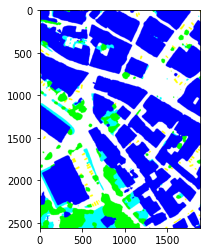

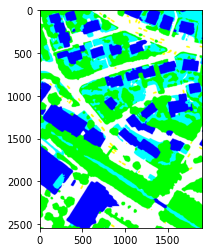

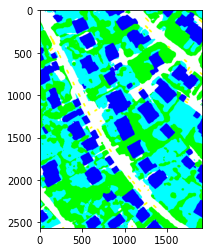

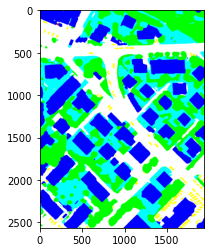

In [22]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./RAUnet_attention_with_4channel_inference_tile_{}.png'.format(id_), img)
